In [1]:
# Parameters

SRCDIR = "."

w = 20
a = 5
min_supp = 0.01
min_conf = 0.5
i_plot = 2

In [2]:
# Imports

from itertools import combinations, chain
from scipy.stats import rankdata, norm
from statsmodels.api import qqplot
import pandas as pd
import numpy as np
import sys

# Plot imports
import bokeh
from bokeh.io import output_notebook
output_notebook(resources=bokeh.resources.Resources(mode='cdn'), hide_banner=True)
from bokeh.io import curdoc, show
from bokeh.models import ColumnDataSource, BoxAnnotation, Grid, LinearAxis, Plot, Text, Span
from bokeh.plotting import figure, output_file, show
from bokeh.models import ColorBar, ColumnDataSource
from bokeh.palettes import Spectral6
from bokeh.plotting import figure, output_file, show
from bokeh.transform import linear_cmap
import matplotlib.pyplot as plt

sys.path.append(SRCDIR)

C:\Users\roque\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
C:\Users\roque\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [3]:
# Plot parameters
plt.rc('figure', titlesize=22)
plt.rc('axes', edgecolor='gray', facecolor='#FAFAFA', 
       titlecolor='#242424', titlesize=22, titlepad=10,
       labelcolor='#242424', labelsize=15)
plt.rc('grid', color='grey', linestyle='dotted', linewidth=0.5, alpha=0.8)
plt.rc('xtick', direction='out', color='#242424', labelsize=15)
plt.rc('ytick', direction='out', color='#242424', labelsize=15)
plt.rc('lines', linewidth=1)
plt.rc('figure.subplot', hspace=0.4)

# Pandas DataFrame
pd.options.display.max_rows = 999
pd.options.display.max_colwidth = 100

::: {.panel-tabset}
# Loading data

In [8]:
# df = pd.read_csv("../dataset_weather/WeatherElectricityInterp.csv", sep=',')
# df = pd.read_csv("../dataset_finance/large/FR0000031122.csv", sep=',')
df = pd.read_csv('input_0.csv', sep=',')

In [9]:
# Create a date_time
df['t'] = pd.to_datetime(df['t'])

In [10]:
print('Columns in the dataframe: ', df.columns.tolist())
print(f'Plotting column {df.columns[i_plot]}')

Columns in the dataframe:  ['t', 'spread', 'abs_imb', 'l1_ask_size', 'l1_bid_size', 'l1_imbalance', 'traded_quantity', 'qty_cancelled', 'qty_modification', 'qty_submission', 'qty_aggressive', 'var_imb', 'd_imb', 'd_mid_price']
Plotting column abs_imb


In [48]:
def plot_original(df, i_plot):
    """
    Plots the i_plot th time series of the input dataframe.
    """
    _, ax = plt.subplots(figsize=(13, 5))

    ax.plot(df['t'], df.iloc[:, i_plot])
    ax.set_title(f'Original data - Column {df.columns[i_plot]}')
    ax.set_xlabel('Time')
    ax.set_ylabel(f'Column {df.columns[i_plot]}')
    
    plt.show()

    return

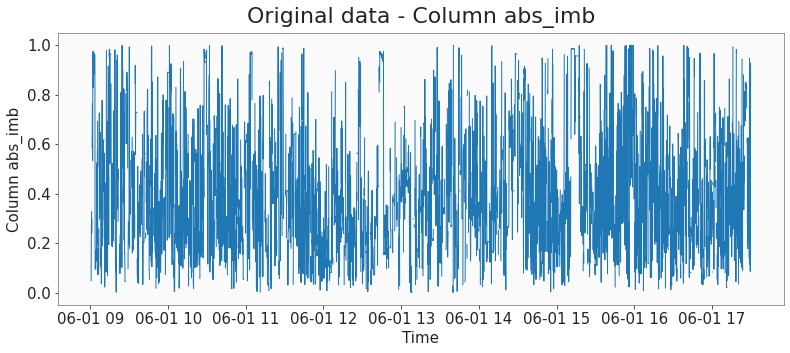

In [49]:
plot_original(df, i_plot)

# INT

In [32]:
def plot_INT(df, df_INT, i_plot):
    
    _, ax = plt.subplots(figsize=(13, 5))

    ax.plot(df_INT['t'], df_INT.iloc[:, i_plot])
    ax.set_title(f'Inverse Normal Transformation - Column {df.columns[i_plot]}')
    ax.set_xlabel('Time')
    ax.set_ylabel(f'Column {df_INT.columns[i_plot]}')
    plt.show()

    f = plt.figure(figsize=(13, 5))
    ax = f.add_subplot(1, 2, 1)
    qqplot(df.iloc[:, i_plot], line='45', ax=ax, c='royalblue', markersize=0.5)
    ax.set_xlabel('Normal Theoretical Quantiles')
    ax.set_ylabel('Data Quantiles')
    ax.set_title(f'QQ-plot - Original data\nColumn {df.columns[i_plot]}')
    
    ax = f.add_subplot(1, 2, 2)
    qqplot(df_INT.iloc[:, i_plot], line='45', ax=ax, c='royalblue', markersize=0.5)
    ax.set_xlabel('Normal Theoretical Quantiles')
    ax.set_ylabel('Data Quantiles')
    ax.set_title(f'QQ-plot - Normalized data\nColumn {df.columns[i_plot]}')

    plt.show()
    
    return

def INT(S, c):
    """
    Rank-based inverse normal transformation is a nonparametric transformation to 
    convert a sample distribution to the normal distribution.
    NaN values are ignored.

    Inputs:
    - S = pandas series 
    - c = Bloms constant

    Output:
    - transformed = normally distributed pandas series 
    """

    # Get rank, ties are averaged
    rank = rankdata(S, method="average")

    # Convert rank to normal distribution
    n = len(rank)
    transformed = norm.ppf((rank-c)/(n-2*c+1))

    return transformed

def INT_step(df, c=3.0/8):
    """
    Transforms all series in a dataframe using the rank-based inverse normal
    transformation.
    """

    # Initialize output DataFrame
    df_INT = pd.DataFrame(index=df.index)
    df_INT['t'] = df['t']

    # Process each column of the input dataframe
    for column in df.columns[1:]:
        df_INT[column] = INT(df[column], c)
    
    # Plot
    plot_INT(df, df_INT, i_plot)

    return df_INT

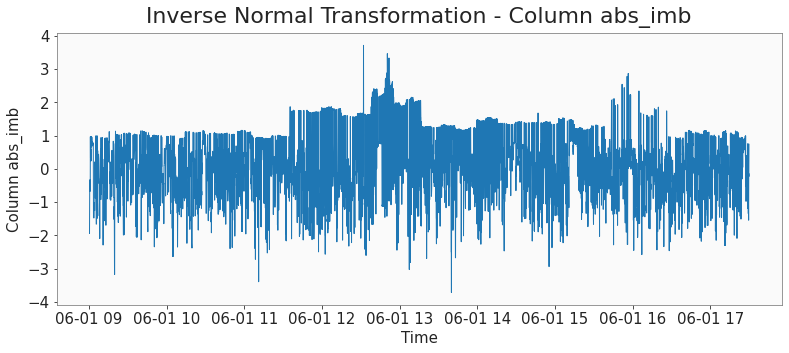

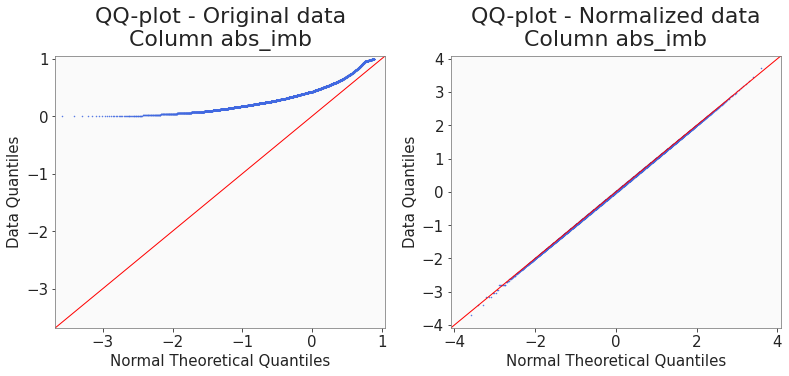

In [33]:
df_INT = INT_step(df)

# SAX: PAA + Discretization

In [34]:
def PAA_step(df_INT, w):
    """
    Piecewise Aggregate Approximation (PAA) (Keogh et. al., 2001) for multivariate 
    time series.

    Inputs:
    - df_INT = Resulting DataFrame from the normalization step 
    - w = number of segments
    """

    n = len(df_INT)

    # Resample dataframe
    new_index = df_INT.index.repeat(w)
    df_temp = df_INT.iloc[:, 1:].reindex(new_index) # Do not apply on the time column

    # Create new re-indexed dataframe from previously re-indexed dataframe
    df_PAA = pd.DataFrame(data=df_temp.to_numpy(),
                          index=[i for i in range(w) for k in range(n)],
                          columns=df_INT.columns[1:])
    
    # Average segments
    df_PAA = df_PAA.groupby(df_PAA.index).mean()
    
    # Create a new correct time column
    new_t = pd.date_range(start=df_INT['t'].iloc[0], 
                          end=df_INT['t'].iloc[-1],
                          periods=w+1)
    df_PAA['t'] = new_t[:-1]
    
    # Reorder columns
    cols = df_PAA.columns.tolist()
    new_cols = cols[-1:] + cols[:-1]
    df_PAA = df_PAA[new_cols]

    return df_PAA

def plot_SAX_plt(df_INT, df_PAA, df_SAX, breakpoints, w, i_plot):
    
    _, ax = plt.subplots(figsize=(13, 5))
    
    for line in breakpoints:
        ax.axhline(line, c='crimson', alpha=0.4, ls='--', lw=0.7)

    dt = df_SAX['t'].iloc[1] - df_SAX['t'].iloc[0]
    for t, letter in enumerate(df_SAX.iloc[:, i_plot]):
        ax.text(df_PAA['t'].iloc[t]+dt/2, 
                df_PAA.iloc[t, i_plot]+0.1, 
                f'{letter}', c='crimson', 
                ha='center', fontsize=15)
        
    # PAA
    ax.step(df_PAA['t'], df_PAA.iloc[:, i_plot], where='post', c='royalblue', alpha=0.9)
    ax.plot([df_PAA['t'].iloc[-1], df_INT['t'].iloc[-1]], 
            [df_PAA.iloc[-1, i_plot], df_PAA.iloc[-1, i_plot]], 
            c='royalblue', alpha=0.9)
    
    # INT Time Series
    ax.plot(df_INT['t'], df_INT.iloc[:, i_plot], alpha=0.5)
    
    ax.set_title(f'SAX Representation - w = {w}, a = {a}\nColumn {df.columns[i_plot]}')
    ax.set_xlabel('Time')
    ax.set_xlim((df_INT['t'].iloc[0], df_INT['t'].iloc[-1]))
    ax.set_ylabel(f'Column {df_INT.columns[i_plot]}')
    plt.show()
    
    return


def plot_PAA(df_INT, df_PAA, df_SAX, breakpoints, w, i_plot):
    
    dt = pd.to_timedelta(df_PAA['t'].iloc[1]-df_PAA['t'].iloc[0])/2
    
    # bokeh parameters
    source = ColumnDataSource(data=dict(
        t=df_PAA['t'],
        paa=df_PAA.iloc[:, i_plot],
        sax=df_SAX.iloc[:, i_plot],
        t_text=df_PAA['t']+dt,
        paa_text=df_PAA.iloc[:, i_plot]+0.01,
    ))
    
    alphabet=np.array([chr(i) for i in range(97, 97 + a)])[:len(breakpoints)+1]
    
    p = figure(title=f'PAA Representation - w = {w}, a = {a}\nColumn {df_SAX.columns[i_plot]}',
               width=800, height=500, x_axis_type='datetime')
    
    #Color dict
    call_colors = bokeh.palettes.all_palettes['RdBu'][len(breakpoints)+1]
    color_key_value_pairs = list(zip(alphabet, call_colors))
    color_dict = dict(color_key_value_pairs)
    
    # Plot step function
    p.step(x='t', y='paa', source=source, line_width=3, line_alpha=0.5, line_color='black', mode='after')
    
    # If w is small enough, show letters
    if w <= 20:
        p.text(x='t_text', y='paa_text', source=source, text='sax', angle=0, text_color='black')
        
    p.line(x=[df_PAA['t'].iloc[-1], df_INT['t'].iloc[-1]],
            y=[df_PAA.iloc[-1, i_plot], df_PAA.iloc[-1, i_plot]],
            line_width=3, line_alpha=0.5, line_color='black')
    
    # Plot breakpoints horizontal lines
    for b in range(len(breakpoints)):
        if b==0:
            annot = BoxAnnotation(top=breakpoints[b], fill_alpha=0.3, fill_color=color_dict[alphabet[b]])
        else:
            annot = BoxAnnotation(bottom=breakpoints[b-1], top=breakpoints[b], 
                                  fill_alpha=0.3, fill_color=color_dict[alphabet[b]])
        p.add_layout(annot)
        
    annot = BoxAnnotation(bottom=breakpoints[b], fill_alpha=0.3, fill_color=color_dict[alphabet[b]])
    p.add_layout(annot)
    p.ygrid.ticker = breakpoints
    
    show(p)
    
    return

def plot_SAX(df_INT, df_PAA, df_SAX, breakpoints, w, i_plot):
    
    # Assign an integer to each letter (for plotting purposes)
    alphabet = np.array([chr(i) for i in range(97, 97 + a)])[:len(breakpoints)+1]
    dico = dict(zip([np.where(alphabet==e)[0][0] for e in alphabet], alphabet))
    reverse_dico={v: k for k, v in dico.items()}
    
    # Make some arrays to plot more easily
    sax = [reverse_dico[e] for e in df_SAX.iloc[:, i_plot]]    
    
    plt.figure(figsize=(13, 5))
    
    # Plot step function
    plt.step(df_SAX['t'], sax, where='post', c='k', linewidth=2, alpha=0.8)
    
    plt.title(f'SAX Representation - w = {w}, a = {a}\nColumn {df_SAX.columns[i_plot]}')
    plt.xticks(rotation='vertical')
    plt.yticks(range(len(alphabet)), alphabet)
    plt.gca().get_yticklabels()[0].set_color('crimson') 
    plt.gca().get_yticklabels()[-1].set_color('crimson') 
    plt.grid()
    
    plt.show()
    
    return


def SAX_step(df_PAA, a):
    """
    Symbolic representation of S_paa.

    Inputs:
    - df_PAA = PAA of a pandas dataframe
    - a = alphabet size.
    """
    
    # Define alphabet from alphabet size and corresponding breakpoints
    alphabet = np.array([chr(i) for i in range(97, 97 + a)])
    breakpoints = norm.ppf(np.linspace(0, 1, a+1)[1:-1])
    
    # Initialize output DataFrame
    df_SAX = pd.DataFrame(index=df_PAA.index)
    df_SAX['t'] = df_PAA['t']
    
    # Process each column of the input dataframe
    for column in df.columns[1:]:
        
        # Convert each value into a letter
        n_timestamps = len(df_PAA)
        discretization = []
        for t in range(n_timestamps):
            
            discretization.append(alphabet[np.searchsorted(breakpoints,
                                                           df_PAA[column].iloc[t],
                                                           side='left')]) 
    
        df_SAX[column] = discretization
    
    # Plot
    plot_PAA(df_INT, df_PAA, df_SAX, breakpoints, w, i_plot)
    plot_SAX(df_INT, df_PAA, df_SAX, breakpoints, w, i_plot)
    
    return df_SAX, alphabet[-1], alphabet[0]

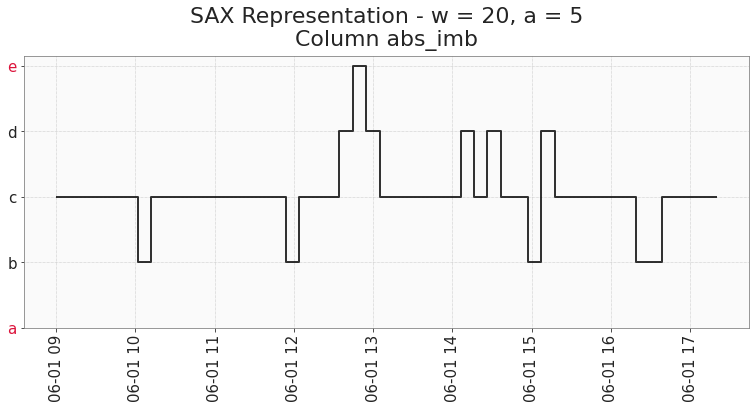

In [39]:
df_PAA = PAA_step(df_INT, w=w)
df_SAX, symb_top, symb_bottom = SAX_step(df_PAA, a=a)

In [40]:
def SBGen(df_SAX, symb_top, symb_bottom, labels=None):
    """ Synbol Basket Generation Algorithm
      Input:
            param1 (symbolized[array(W x M)]):   Multivariate Time Series 
            param2 (symtop['string']):  Symbol of interest (from alphabet)
            param3 (symbottom['string']):  Symbol of interest (from alphabet)
      Returns:
            array
    """ 

    data = {
      'symb_basket_id': [],
      'time_series_id': [],
      'symbol': []
    }
    
    n_t, n_series = df_SAX.shape

    #Initialization
    B = []
    for i_t in range(n_t):
        b = []

        for i_series in range(n_series):
            symb = df_SAX.iloc[i_t, i_series]

            if symb in [symb_top, symb_bottom]:
                
                # If DataFrame has columns, keep the columns names
                # in the baskets. Otherwise keep integer index.
                if not(labels is None):
                    i_series = labels[i_series]
                
                b.append((i_series, symb)) 

                data['symb_basket_id'].append(i_t)
                data['time_series_id'].append(i_series)
                data['symbol'].append(symb)

        # Only add b if it is not empty
        if b:
            B.append(b)
    
    # Support for deviant events
    df = pd.DataFrame(data=data)
    supp = df.groupby(['time_series_id', 'symbol']).count()/n_t
    supp = supp.unstack(level=-1)
    supp.columns = supp.columns.droplevel(level=0)
    supp.columns.name = None
       
    # Depending on the choice of w and a, there may not be top or bottom symbols
    if (not(symb_top in data['symbol'])) and (not(symb_bottom in data['symbol'])):
        print('No maximal deviant symbols! Change parameters w or a for better rules.')
        return B, supp
    else:
        if not(symb_top in data['symbol']):
            supp[f'{symb_top}'] = np.zeros(len(supp))
            print('No maximal deviant symbol! Change parameters w or a for better rules.')
        if not(symb_bottom in data['symbol']):
            supp[f'{symb_bottom}'] = np.zeros(len(supp))
            print('No maximal deviant symbol! Change parameters w or a for better rules.')
        
    supp['Sum'] = supp[f'{symb_top}'] + supp[f'{symb_bottom}']
    supp = supp.rename(columns={f'{symb_top}': f'support({symb_top})',
                              f'{symb_bottom}': f'support({symb_bottom})'})

    return B, supp.sort_values('Sum', ascending=False)

In [41]:
B, support = SBGen(df_SAX, symb_top, symb_bottom, df_SAX.columns)

In [42]:
support

,support(a),support(e),Sum
time_series_id,,,
l1_ask_size,0.04,0.02,0.06
abs_imb,NaN,0.02,NaN
l1_bid_size,0.04,NaN,NaN
qty_aggressive,0.02,NaN,NaN
qty_modification,0.02,NaN,NaN
qty_submission,0.02,NaN,NaN


# Association Rule Mining: Apriori algorithm

In [41]:
class Transactions():
    """
    Transactions manager
    """

    def __init__(self, transactions):
        """
        transactions = list of transactions
        """
        self.n_transactions = 0 # Total number of transactions
        self.items = [] # Individual transactions
        self.transactions_map = {} # Indices of individual transactions
        
        for transaction in transactions:
            self.add_transaction(transaction)

    def add_transaction(self, transaction):
        for item in transaction:
            if item not in self.transactions_map:
                self.items.append(item)
                self.transactions_map[item] = set()
            self.transactions_map[item].add(self.n_transactions)
        self.n_transactions += 1

    def compute_support(self, candidate):
        """
        Computes the support for a candidate transaction.
        Support is computed by counting the indices of the intersection
        between items in the transaction. 
        """

        for i_item, item in enumerate(candidate):
            item_indexes = self.transactions_map.get(item)

            # If the candidate transaction cannot be found in the data
            if item_indexes == None:
                return 0

            # Otherwise, find the number of times the items appear
            # in the transactions
            else:
                if i_item == 0:
                    indexes = item_indexes
                else:
                    indexes = indexes.intersection(item_indexes)

        return len(indexes)/self.n_transactions

    def initial_candidates(self):
        """
        Initial candidates.
        """
        return [frozenset([item]) for item in self.items]


def apriori_gen(candidates, k):
    """
    Takes list of itemsets of size k and returns a list of all (k+1)-itemsets.
    A new itemset is added to the new list of candidates if all of its 
    subsets can be generated from the list of previous candidates.

    join is first created as a generator as it saves memory space. 
    """
    #############
    # Join step #
    #############

    # 'Removes' the frozenset type 
    join = sorted(frozenset(chain.from_iterable(candidates))) 
    # Generates new candidates
    join = (frozenset(x) for x in combinations(join, k))

    ##############
    # Prune step #
    ##############

    # if k==2, all subsets are of size k=1 and are necessarily present in 
    # the list of previous candidates 
    if k == 2:
        return list(join)
    else:   
        new_candidates = [
            candidate for candidate in join
            if all(
                frozenset(x) in join
                for x in combinations(candidate, k-1))
        ]

    return new_candidates


def compute_supports(manager, min_supp):
    """
    Computes the support for each itemsets. New candidates are generated using
    Agrawal et. al.'s apriori_gen function.

    Inputs:
    - manager = Transaction object containing transactions informations.
    - min_supp = Transaction minimal support. Transactions with a support
    below this value will not be taken into consideration.

    Output:
    - Dictionary of transactions and their support. 
    """

    supports = {}

    candidates = manager.initial_candidates()

    k = 1
    while candidates:
        relations = set()

        for candidate in candidates:
            support = manager.compute_support(candidate)

            # Candidates with a low support are not selected
            if support < min_supp:
                continue

            relations.add(frozenset(candidate))
            supports[candidate] = support

        k += 1
        candidates = apriori_gen(relations, k)

    return supports


def compute_rules(manager, supports, min_conf):
    """
    Mines association rules to discover frequent patterns of deviant events
    that occur simultaneously.

    Inputs:
    - manager = Transaction object containing transactions informations.
    - supports = Dictionary of events and their support returned by the 
    compute_supports function.
    - min_conf = Rule minimal confidence. Rules with a confidence below this
    value will be filtered out from the resulting DataFrame.

    Output:
    - DataFrame with association rules and their metrics (support, confidence,
    lift) sorted by descending support.  
    """

    data = {
      'Rule': [],
      'Support': [],
      'Confidence': [],
      'Lift': []
    }

    # Iterate over transactions
    for items in supports:

        # Can't find rules if there is only one item in the set
        if len(items) == 1:
            continue

        # If the set contains more than one item
        else:
            sorted_items = sorted(items)

            # Create rules for each possible subset in items
            for length in range(1, len(items)):

                for combination in combinations(sorted_items, length):
                    A = frozenset(combination)
                    B = frozenset(items.difference(A))

                    # Compute metrics for each rule
                    support = supports[items]
                    confidence = support/manager.compute_support(A)
                    lift = confidence/manager.compute_support(B)

                    data['Rule'].append(f'{set(A)} --> {set(B)}')
                    data['Support'].append(support)
                    data['Confidence'].append(confidence)
                    data['Lift'].append(lift)

    # Return filtered results using the min_conf criteria 
    rules = pd.DataFrame(data=data)

    return rules.loc[rules['Confidence'] >= min_conf].sort_values('Support', ascending=False)


def apriori(B, min_supp, min_conf=0):
    """
    A priori algorithm, as defined in Agrawal et. al. (1984). This implementation
    is heavily inspired by: https://github.com/ymoch/apyori/blob/master/apyori.py

    Contrary to Park et. al., support for an event A is computed as:
    support(A) = (number of transactions in which A appear) / (total number of 
    transactions). 
    Park et. al. rather use the number of time segments as the denominator.

    Inputs:
    - basket = Symbol Basket, defined in Park et. al. (2019).
    - min_supp = minimal support for a deviant event to be taken into
    consideration

    Output:
    - DataFrame with association rules and their metrics (support, confidence,
    lift) sorted by descending support.  
    """

    manager = Transactions(B)

    supports = compute_supports(manager, min_supp)
    
    rules = compute_rules(manager, supports, min_conf)

    return rules

In [42]:
rules = apriori(B, min_supp=min_supp, min_conf=min_conf)

In [43]:
rules

,Rule,Support,Confidence,Lift
85,"{('temp_Lille', 'e')} --> {('mean_national_temp', 'e')}",0.545455,1.000000,1.833333
84,"{('mean_national_temp', 'e')} --> {('temp_Lille', 'e')}",0.545455,1.000000,1.833333
89,"{('temp_Lille', 'e')} --> {('temp_Aix', 'e')}",0.454545,0.833333,1.833333
88,"{('temp_Aix', 'e')} --> {('temp_Lille', 'e')}",0.454545,1.000000,1.833333
83,"{('temp_Aix', 'e')} --> {('mean_national_temp', 'e')}",0.454545,1.000000,1.833333
82,"{('mean_national_temp', 'e')} --> {('temp_Aix', 'e')}",0.454545,0.833333,1.833333
61,"{('mean_national_temp', 'e')} --> {('consumption_Paris', 'a')}",0.272727,0.500000,1.833333
32,"{('consumption_Angers', 'a')} --> {('temp_Aix', 'e')}",0.272727,1.000000,2.200000
33,"{('temp_Aix', 'e')} --> {('consumption_Angers', 'a')}",0.272727,0.600000,2.200000
34,"{('consumption_Angers', 'a')} --> {('temp_Lille', 'e')}",0.272727,1.000000,1.833333


:::